In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import parent
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import data
import matplotlib.pyplot as plt
import numpy as np

In [6]:
_, medresknees = data.get_knees_dataset()

In [8]:

BATCH_SIZE = 24
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
working_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

net = inverseConsistentNet.InverseConsistentAffineDeformableNet(
    networks.ConvolutionalMatrixNet(dimension=3),
    networks.tallUNet2(dimension=3),
    lmbda=100,
    input_shape=working_shape,
)

net.load_state_dict(torch.load("../results/aff_aff_def_knee_frozen_affine/knee_aligner_resi_net12000"))

/playpen-raid1/tgreer/InverseConsistency/networks.py:390: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


<All keys matched successfully>

In [9]:
net.cuda()

InverseConsistentAffineDeformableNet(
  (affine_regis_net): ConvolutionalMatrixNet(
    (convs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (dense2): Linear(in_features=512, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=12, bias=True)
  )
  (regis_net): UNet2(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      

In [6]:
def make_batch():
    image = torch.cat([random.choice(medresknees) for _ in range(BATCH_SIZE)])
    image = image[:, None]
    image = image.cuda()
    return image

In [7]:
moving_image, fixed_image = make_batch(), make_batch()

In [8]:
net(moving_image, fixed_image)

[tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.3147, device='cuda:0', grad_fn=<MulBackward0>)]

In [175]:
import matplotlib.pyplot as plt

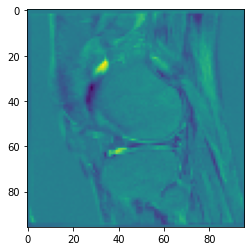

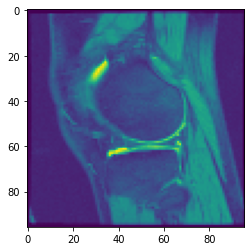

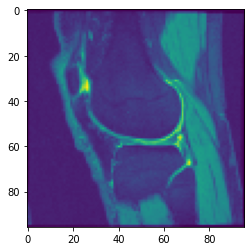

In [193]:
N += 1
N %= 3
plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(fixed_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(moving_image[N, 0, 10].cpu().detach())

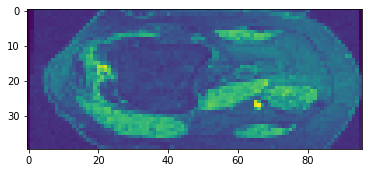

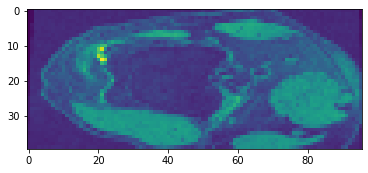

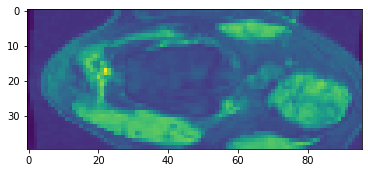

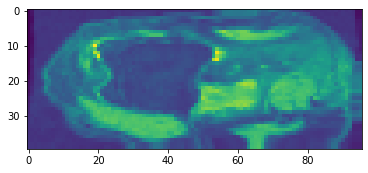

In [196]:
import matplotlib.pyplot as plt
N = 2
plt.imshow(moving_image[N, 0, :, 20].cpu())
plt.show()
plt.imshow(fixed_image[N, 0, :, 20].cpu())
plt.show()
plt.imshow(net.warped_image_A[N, 0, :, 20].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[N, 0, :, 20].cpu().detach())

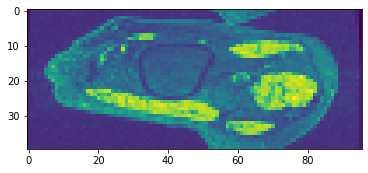

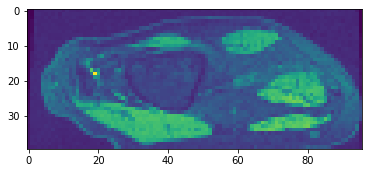

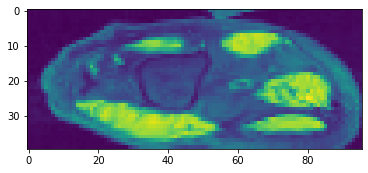

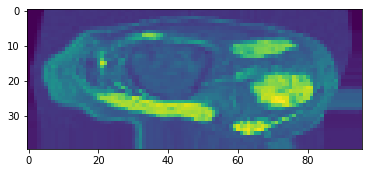

In [198]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())

In [179]:
net.matrix_AB[22].cpu().detach().numpy()

array([[ 0.8921268 ,  0.01366304, -0.02698795, -0.00230147],
       [-0.02714648,  0.8886366 ,  0.04763453, -0.02069031],
       [-0.02109941, -0.01767839,  0.9114483 ,  0.10829491],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [180]:
import numpy as np
np.set_printoptions(suppress=True)

In [181]:
len(list(net.parameters()))

48

In [182]:
next(net.parameters()).requires_grad

True

In [183]:
len(list(net.affine_regis_net.parameters()))

16

In [199]:
import visualize

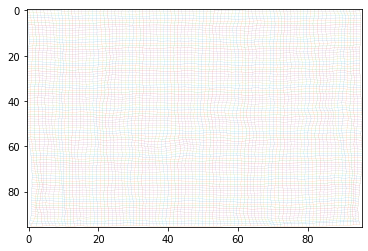

In [202]:
visualize.show_as_grid((net.approximate_zero + net.identityMap)[0, [1, 2], 20])

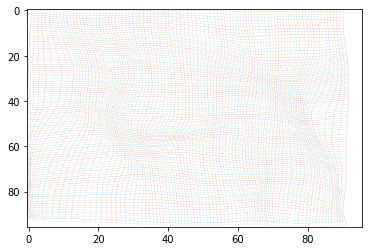

In [203]:
visualize.show_as_grid(net.phi_AB[0, [1, 2], 20])

In [11]:
import pickle
with open("/playpen/tgreer/cartilage_uint8s.trch", "rb") as f:
    cartilage = torch.load(f)

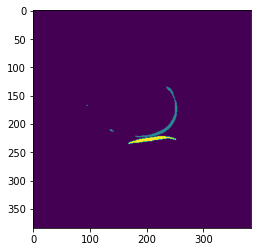

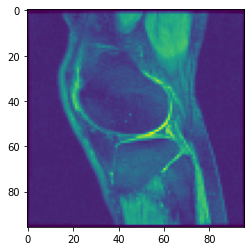

In [12]:
N = 1
plt.imshow(cartilage[N][0, 40])
plt.show()
plt.imshow(medresknees[N][0, 10])



In [15]:
net.adjust_batch_size(BATCH_SIZE // 8)
net.cuda()

InverseConsistentAffineDeformableNet(
  (affine_regis_net): ConvolutionalMatrixNet(
    (convs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (dense2): Linear(in_features=512, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=12, bias=True)
  )
  (regis_net): UNet2(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      

In [168]:
def make_test_batch():
    index = [random.randint(0, 240 - 1) for _ in range(BATCH_SIZE// 8)]
    image = torch.cat([medresknees[index[_]] for _ in range(BATCH_SIZE // 8)])
    image = image.reshape(BATCH_SIZE // 8, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE)
    image = image.cuda()
    #print(image.shape)
    cartilage_batch = torch.cat([cartilage[index[_]][None, :, :, :, :] for _ in range(BATCH_SIZE // 8)])
    #cartilage_batch = cartilage_batch[:, None, :]
    #print(cartilage_batch.shape)
    cartilage_batch = cartilage_batch.cuda()
    return image, cartilage_batch

fixed_image, fixed_cartilage = make_test_batch()
moving_image, moving_cartilage = make_test_batch()


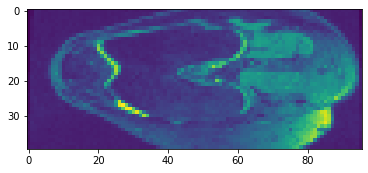

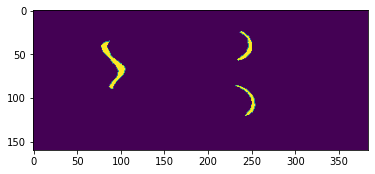

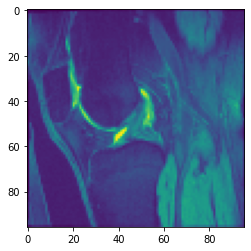

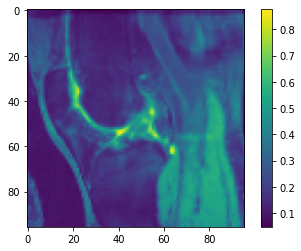

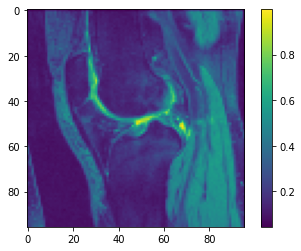

In [169]:
net(moving_image, fixed_image)

#N +=1
N %= 3
S =46
plt.imshow(moving_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow(moving_image[N, 0, 16].detach().cpu())
plt.show()
plt.imshow(net.warped_image_B[N, 0, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, 16].cpu())
plt.colorbar()
plt.show()


In [185]:
fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB[:, :3])
sz = np.array(fat_phi.size())
spacing = 1./(sz[2::]-1) 
warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)

def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0) / 3

flips(net.phi_AB[:, :3])

flips(fat_phi[:, :, ::2, ::2, ::2])

tensor(0.3333, device='cuda:0')

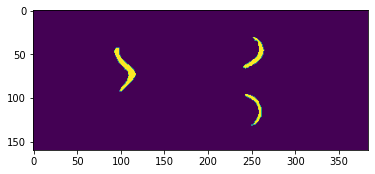

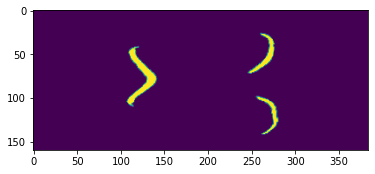

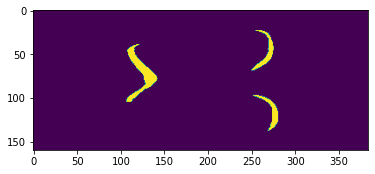

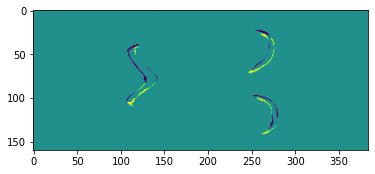

In [205]:
N +=1
N %= 3
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

In [206]:

dices = []
for _ in range(70):
    fixed_image, fixed_cartilage = make_test_batch()
    moving_image, moving_cartilage = make_test_batch()
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
    print(d)
    dices.append(d)


/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.7109, device='cuda:0')
tensor(0.6872, device='cuda:0')
tensor(0.7172, device='cuda:0')
tensor(0.6967, device='cuda:0')
tensor(0.6690, device='cuda:0')
tensor(0.7202, device='cuda:0')
tensor(0.6456, device='cuda:0')
tensor(0.7101, device='cuda:0')
tensor(0.7154, device='cuda:0')
tensor(0.6648, device='cuda:0')
tensor(0.7604, device='cuda:0')
tensor(0.6939, device='cuda:0')
tensor(0.7163, device='cuda:0')
tensor(0.5653, device='cuda:0')
tensor(0.7238, device='cuda:0')
tensor(0.6756, device='cuda:0')
tensor(0.7395, device='cuda:0')
tensor(0.6710, device='cuda:0')
tensor(0.6793, device='cuda:0')
tensor(0.6686, device='cuda:0')
tensor(0.6753, device='cuda:0')
tensor(0.7471, device='cuda:0')
tensor(0.7004, device='cuda:0')
tensor(0.7173, device='cuda:0')
tensor(0.6940, device='cuda:0')
tensor(0.7339, device='cuda:0')
tensor(0.6583, device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor(0.6808, device='cuda:0')
tensor(0.6989, device='cuda:0')
tensor(0.7315, device='cuda:0')
tensor(0

In [207]:
np.mean([d.item() for d in dices])

0.6923711785248348

In [208]:
import os
files = os.listdir("../results/aff_aff_def_knee_frozen_affine/")
files = [f for f in files if "_net" in f]
files

['knee_aligner_resi_net0',
 'knee_aligner_resi_net300',
 'knee_aligner_resi_net600',
 'knee_aligner_resi_net900',
 'knee_aligner_resi_net1200',
 'knee_aligner_resi_net1500',
 'knee_aligner_resi_net1800',
 'knee_aligner_resi_net2100',
 'knee_aligner_resi_net2400',
 'knee_aligner_resi_net2700',
 'knee_aligner_resi_net3000',
 'knee_aligner_resi_net3300',
 'knee_aligner_resi_net3600',
 'knee_aligner_resi_net3900',
 'knee_aligner_resi_net4200',
 'knee_aligner_resi_net4500',
 'knee_aligner_resi_net4800',
 'knee_aligner_resi_net5100',
 'knee_aligner_resi_net5400',
 'knee_aligner_resi_net5700',
 'knee_aligner_resi_net6000',
 'knee_aligner_resi_net6300',
 'knee_aligner_resi_net6600',
 'knee_aligner_resi_net6900',
 'knee_aligner_resi_net7200',
 'knee_aligner_resi_net7500',
 'knee_aligner_resi_net7800',
 'knee_aligner_resi_net8100',
 'knee_aligner_resi_net8400',
 'knee_aligner_resi_net8700',
 'knee_aligner_resi_net9000',
 'knee_aligner_resi_net9300',
 'knee_aligner_resi_net9600',
 'knee_aligner_r

In [209]:
#diceHistory = []
for f in files[len(diceHistory):]:
    net.adjust_batch_size(BATCH_SIZE)
    net.load_state_dict(torch.load("../results/aff_aff_def_knee_frozen_affine/" + f))
    net.adjust_batch_size(BATCH_SIZE // 8)
    net.cuda()
    dices = []
    for _ in range(70):
        fixed_image, fixed_cartilage = make_test_batch()
        moving_image, moving_cartilage = make_test_batch()
        net(moving_image, fixed_image)
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
        wmb = warped_moving_cartilage > .5
        fb = fixed_cartilage > .5
        intersection = wmb * fb
        d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
        #print(d)
        dices.append(d)
    dd = np.mean([d.item() for d in dices])
    print(dd)
    diceHistory.append(dd)

0.6926472204072135
0.6999394195420402
0.6986599487917764
0.6876843469483512
0.6955779075622559
0.7042530715465546
0.7004769452980586
0.6974632399422782
0.6969716787338257
0.6987906498568398
0.6974519959517888
0.7059660886015211
0.6984479878629957
0.6981185827936445
0.6917129252638136
0.6991455818925585
0.6953306589807783
0.6892880116190229
0.7011388855321067
0.6974498621055059
0.7013198609863008
0.6941102364233562
0.6934895949704306
0.6837713233062199
0.6968829487051282
0.7066599939550672
0.6882289469242096
0.7037748192037855
0.7024069011211396


In [284]:
cartilage[0].int8

AttributeError: 'Tensor' object has no attribute 'int8'

In [286]:
cartilage[0].type(torch.ByteTensor)

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 

In [287]:
compressed_cart = [c.type(torch.ByteTensor) for c in cartilage]

In [289]:
torch.save(compressed_cart, "/playpen/tgreer/cartilage_uint8s.trch")

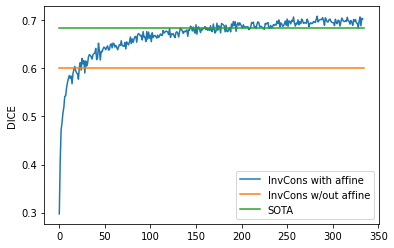

In [210]:
plt.plot(diceHistory, label="InvCons with affine")
plt.plot([0, len(diceHistory)], [.60, .60], label="InvCons w/out affine")
plt.plot([0, len(diceHistory)], [.684, .684], label="SOTA")
plt.ylabel("DICE")
plt.legend()

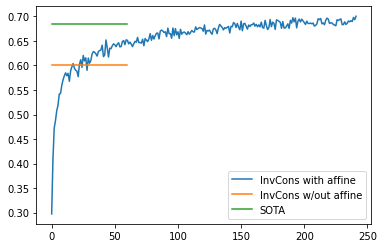

In [172]:
plt.plot(diceHistory, label="InvCons with affine")
plt.plot([0, 60], [.60, .60], label="InvCons w/out affine")
plt.plot([0, 60], [.684, .684], label="SOTA")
plt.legend()

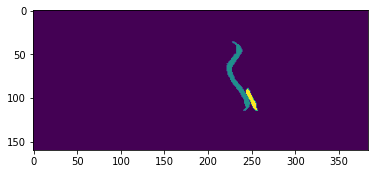

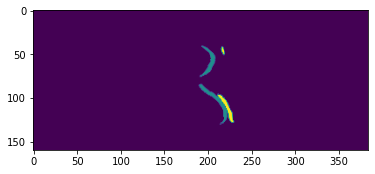

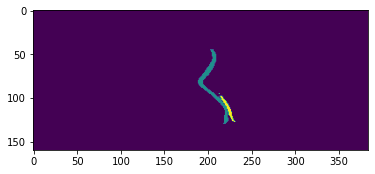

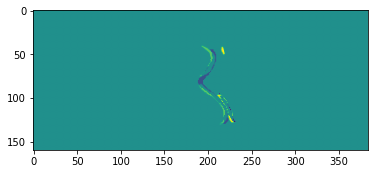

In [213]:
N =0
S = 40
plt.imshow(moving_cartilage[N, 0, :, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :,:, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :,:, S * 4].cpu())
plt.show()

plt.imshow(warped_moving_cartilage[N, 0, :,:, S * 4].detach().cpu() - fixed_cartilage[N, 0, :,:, S * 4].cpu())
plt.show()



In [177]:
ds = np.array([d.item() for d in dices])

In [182]:
np.sqrt(np.mean((ds - np.mean(ds))**2))

0.04226305800018859

In [216]:
np.mean(diceHistory[-50:])

0.6975856225149971

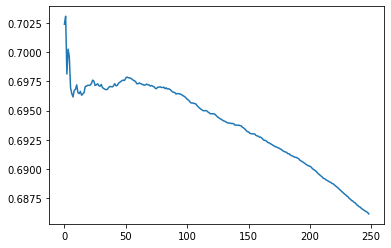

In [223]:
plt.plot([np.mean(diceHistory[-j:]) for j in range(1, 250)])

In [219]:
diceHistory[-1]

0.7024069011211396

In [222]:
diceHistory[-2:]

[0.7037748192037855, 0.7024069011211396]

In [224]:
len(cartilage)

240